In [2]:
import os
import cv2
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt

from skimage.color import rgb2gray
from skimage.morphology import binary_opening, binary_erosion, binary_dilation, binary_closing
from skimage.filters import threshold_local, try_all_threshold, threshold_otsu, gaussian
from skimage.measure import regionprops
from skimage.measure import label as sk_measure_label

In [3]:
def get_largest_component(mask):
    labels = sk_measure_label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
        
#     print("Значения площади для каждой компоненты связности: {}".format(areas))
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

#     print("labels - матрица, заполненная индексами компонент связности со значениями из множества: {}".format(np.unique(labels)))
    return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

In [4]:
def get_largest_component_by_num(mask, num):
    labels = sk_measure_label(mask) # компоненты связности
    props = regionprops(labels) # свойства каждой области
    areas = np.array([prop.area for prop in props]) # площади компонент связности
        
    areas_copy = areas.copy()
    sorted_indexes = np.array([])

    for i in range(areas.size):
        largest_comp_id = np.array(areas_copy).argmax() # номер компоненты с максимальной площадью
        sorted_indexes = np.append(sorted_indexes, largest_comp_id)
        areas_copy[largest_comp_id] = 0
        
#     print("Значения площади для каждой компоненты связности: {}".format(areas))
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

#     print("labels - матрица, заполненная индексами компонент связности со значениями из множества: {}".format(np.unique(labels)))
    return labels == (sorted_indexes[num] + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

In [5]:
def bradley_roth_threshold(image):
    img = np.array(image).astype(float)
    width = image.shape[1]
    height = image.shape[0]
    
    # Будем разбивать изображение на прямоугольники со стороной s
    s = np.round(width/8)
    s = s + np.mod(s,2) # если s - нечетное:
    
    # Среднее значение интенсивности в каждом прямоугольнике будем изменять на величину t(%)
    t = 15.0

    # Интегральное изображение
    integral_image = cv2.integral(image)
    
    # Строим сетку пикселей
    (X,Y) = np.meshgrid(np.arange(width), np.arange(height))
    X = X.ravel()
    Y = Y.ravel()

    # Получаем все координаты соседних фрагментов
    x1 = X - s/2
    x2 = X + s/2
    y1 = Y - s/2
    y2 = Y + s/2

    # Поправляем координаты, вышедшие за границы изображения
    x1[x1 < 0] = 0
    x2[x2 >= width] = width - 1
    y1[y1 < 0] = 0
    y2[y2 >= height] = height - 1

    x1 = x1.astype(int)
    x2 = x2.astype(int)
    y1 = y1.astype(int)
    y2 = y2.astype(int)

    # Находим количество пикселей в каждой области
    count = (x2 - x1) * (y2 - y1)

    # Правый нижний фрагмент
    f1_x = x2
    f1_y = y2
    
    # Правый верхний
    f2_x = x2
    f2_y = y1 - 1
    f2_y[f2_y < 0] = 0 # если вышли за границу изображения
    
    # Левый нижний
    f3_x = x1-1
    f3_x[f3_x < 0] = 0 # если вышли за границу изображения
    f3_y = y2
    
    # Левый верхний
    f4_x = f3_x
    f4_y = f2_y

    # Вычисляем сумму значений яркостей по областям
    sums = integral_image[f1_y, f1_x] - integral_image[f2_y, f2_x] - integral_image[f3_y, f3_x] + integral_image[f4_y, f4_x]

    res = np.ones(height * width, dtype=bool)
    res[img.ravel() * count <= sums * (100.0 - t)/100.0] = False

    res = 255 * np.reshape(res, (height, width)).astype(np.uint8)

    return res

## Получим маски для шаблонных изображений

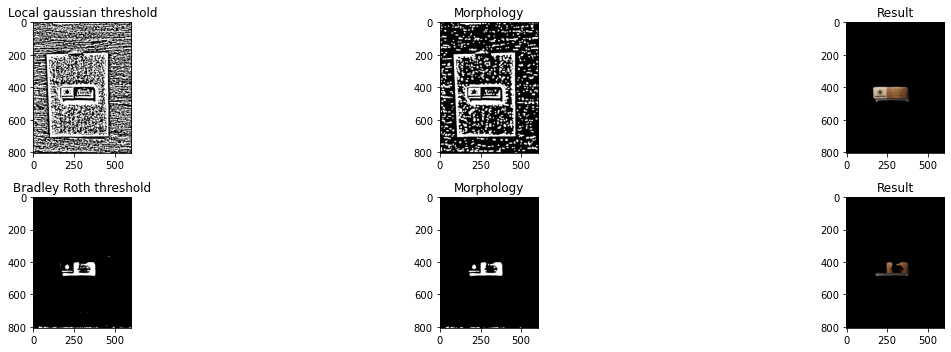

In [36]:
image_path = os.path.join('input\objects', '1_1.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)

fig, ax = plt.subplots(2, 3, figsize=(20, 5))

# Используем локальное пороговое значение, полученное с помощью фильтра Гаусса
background_threshold = threshold_local(gray_image, 37, method='gaussian')
threshold_res = gray_image >= background_threshold
ax[0, 0].imshow(threshold_res, cmap="gray")

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[0, 1].imshow(threshold_res_enclosed, cmap="gray")

# Используя модифицированную функцию, выбираем вторую по площади компоненту вокруг объекта
result_mask = get_largest_component_by_num(1 - get_largest_component_by_num(threshold_res_enclosed, 1), 1)
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[0, 2].imshow(result, cmap="gray")


# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[1, 0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1, 1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[1, 2].imshow(result, cmap='gray')

for i, title in enumerate(["Local gaussian threshold", "Morphology", "Result"]):
    ax[0, i].set_title(title)
    
for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[1, i].set_title(title)
    
fig.tight_layout()

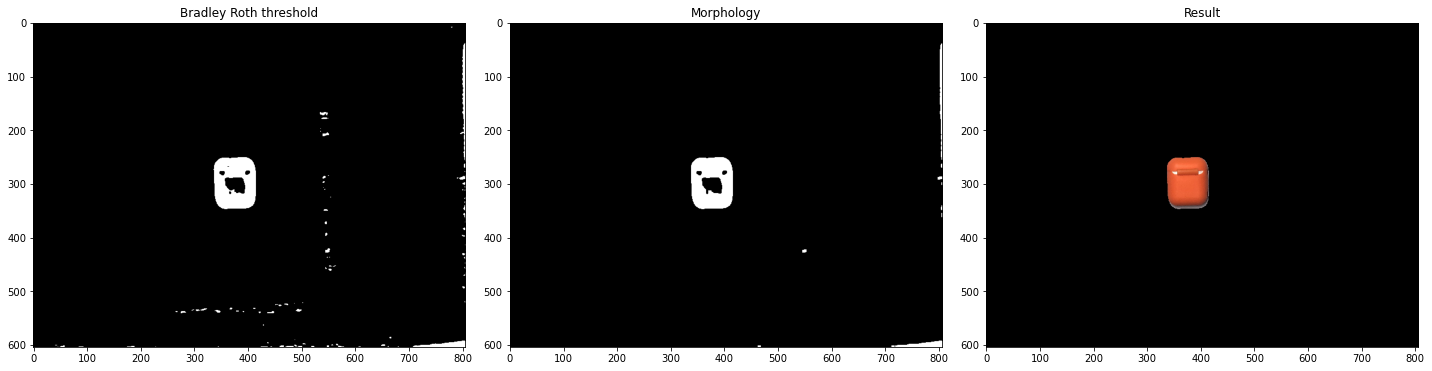

In [166]:
image_path = os.path.join('input\objects', '2.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

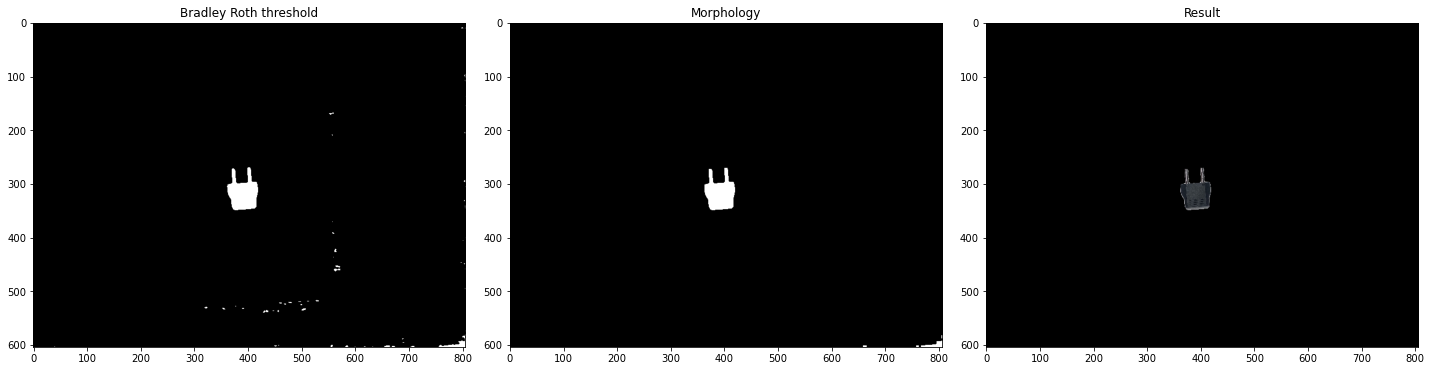

In [165]:
image_path = os.path.join('input\objects', '3.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

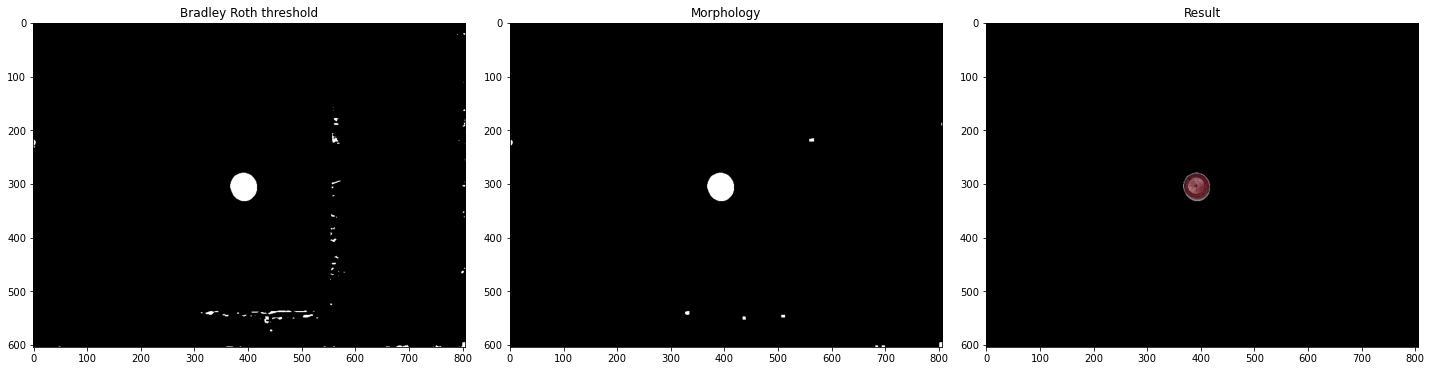

In [167]:
image_path = os.path.join('input\objects', '4.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

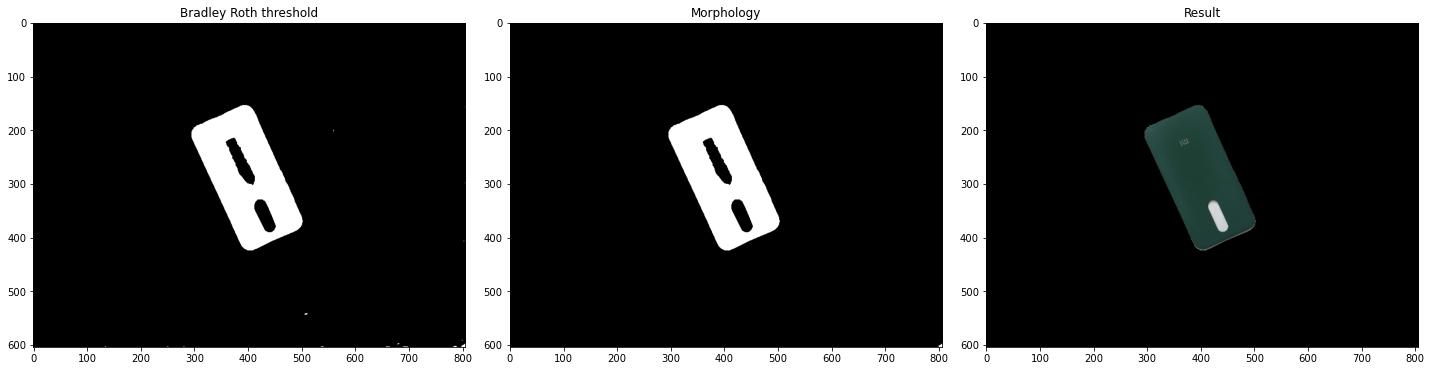

In [168]:
image_path = os.path.join('input\objects', '5.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

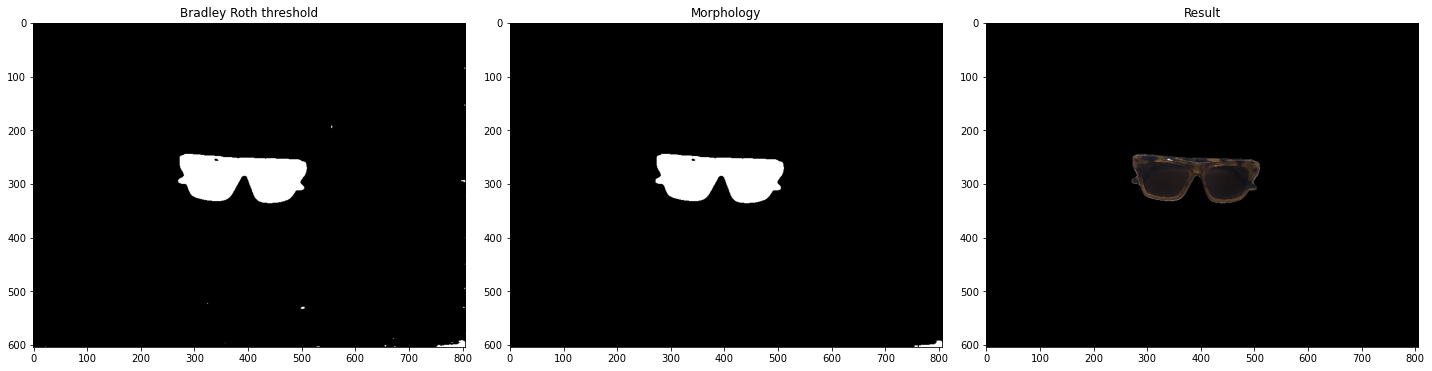

In [169]:
image_path = os.path.join('input\objects', '6.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

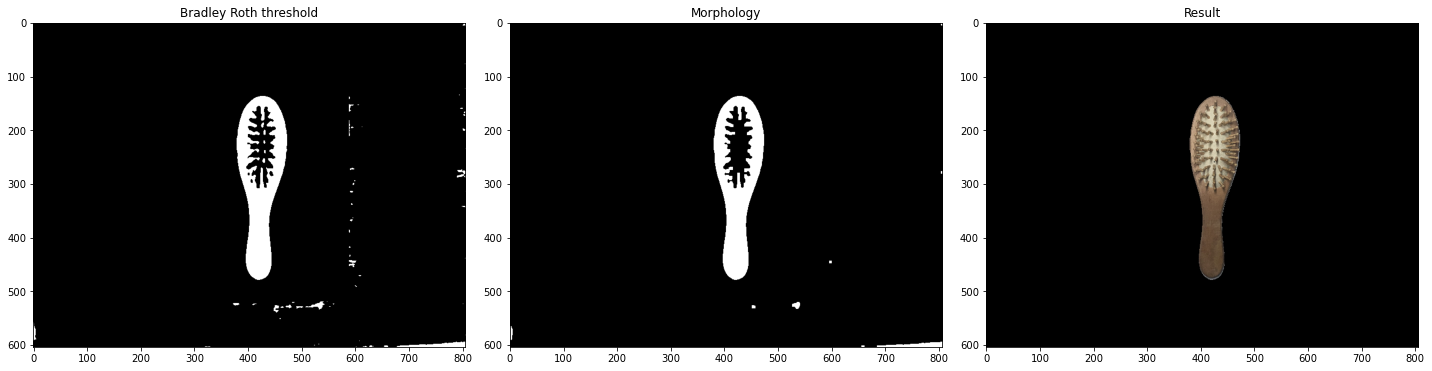

In [170]:
image_path = os.path.join('input\objects', '7.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

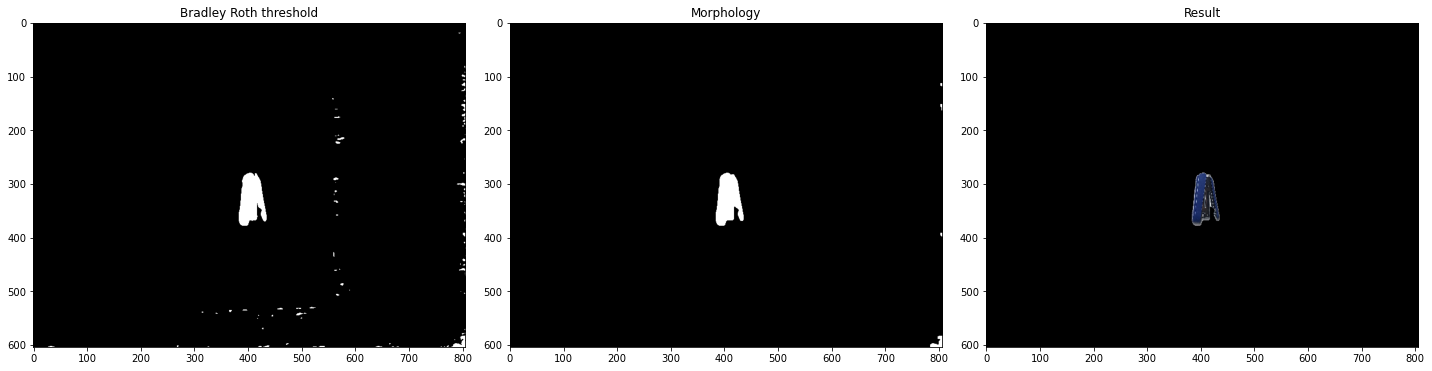

In [171]:
image_path = os.path.join('input\objects', '8.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

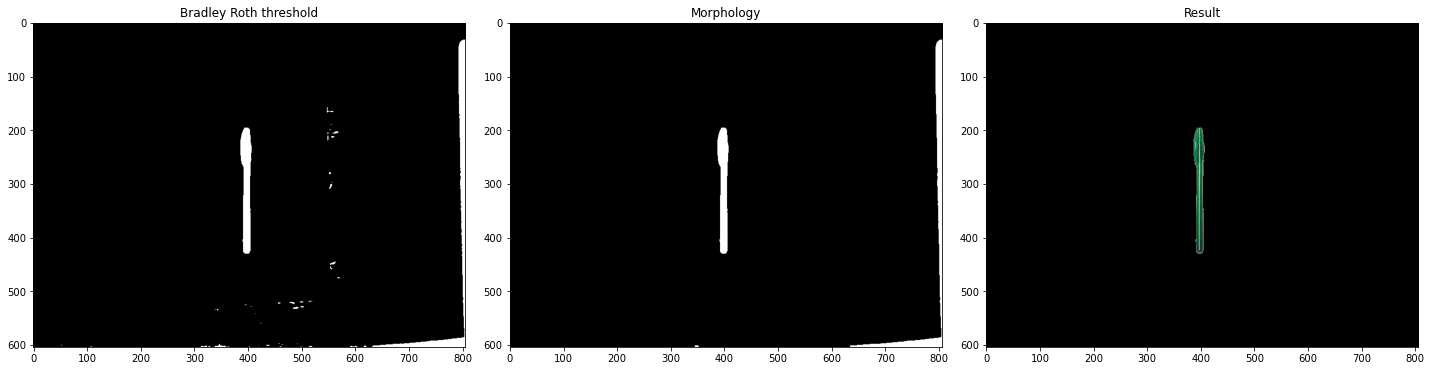

In [192]:
image_path = os.path.join('input\objects', '9.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

# убираем лишнее вне предмета, ручка - вторая по величине компонента, используем модифицированную функцию
object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 1)
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

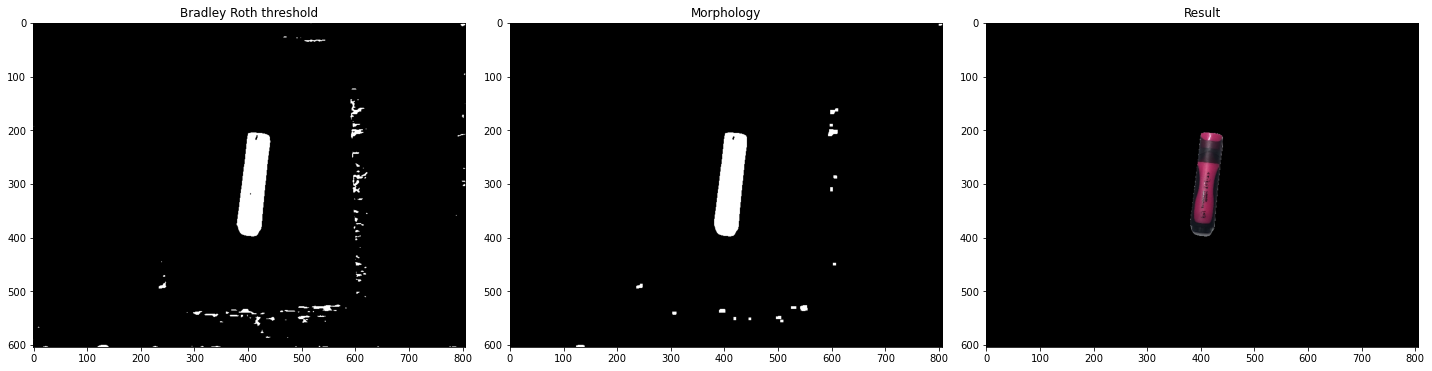

In [173]:
image_path = os.path.join('input\objects', '10.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

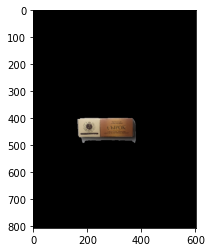

In [37]:
image_path = os.path.join('input\objects', '1_1.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)

# Используем локальное пороговое значение, полученное с помощью фильтра Гаусса
background_threshold = threshold_local(gray_image, 37, method='gaussian')
threshold_res = gray_image >= background_threshold

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))

# Используя модифицированную функцию, выбираем вторую по площади компоненту вокруг объекта
result_mask = get_largest_component_by_num(1 - get_largest_component_by_num(threshold_res_enclosed, 1), 1)
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
plt.imshow(result, cmap='gray')

# # Используем алгоритм определения порога Брэдли-Рота
# bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))

# bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
# bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))

# object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
# inverted_object_mask =  1 - object_mask
# result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
# result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
# plt.imshow(result, cmap='gray')
    
fig.tight_layout()

# Сохранение полученного изображения в файл
binarization_result = os.path.join("input\objects\masks", "1_1_mask.png")
plt.savefig(binarization_result)

## Получим маски для поверхности, чтобы далее отделять предметы и многоугольник

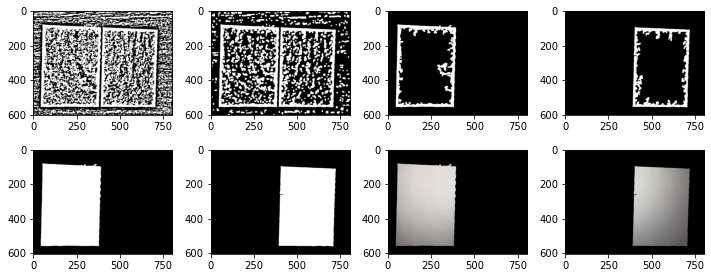

In [214]:
background_path = os.path.join('input\\tests', 'background.jpeg')
background = imread(background_path)

compressed_background = cv2.resize(background, [int(background.shape[1] * 0.2), int(background.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_background = gaussian(compressed_background, sigma=1.5, channel_axis=2)
gray_background = rgb2gray(filtered_background)

fig, ax = plt.subplots(2, 4, figsize=(10, 4))

background_threshold = threshold_local(gray_background, 47, method='gaussian')
threshold_res = gray_background >= background_threshold
ax[0, 0].imshow(threshold_res, cmap="gray")

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[0, 1].imshow(threshold_res_enclosed, cmap="gray")

# Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
component_of_left_sheet = get_largest_component_by_num(threshold_res_enclosed, 0)
component_of_right_sheet = get_largest_component_by_num(threshold_res_enclosed, 1)
ax[0, 2].imshow(component_of_left_sheet, cmap="gray")
ax[0, 3].imshow(component_of_right_sheet, cmap="gray")

left_sheet_mask = 1 - get_largest_component(1 - component_of_left_sheet)
right_sheet_mask = 1 - get_largest_component(1 - component_of_right_sheet)

ax[1, 0].imshow(left_sheet_mask, cmap="gray")
ax[1, 1].imshow(right_sheet_mask, cmap="gray")
ax[1, 2].imshow(cv2.bitwise_and(compressed_background,compressed_background,mask = left_sheet_mask.astype("uint8")), cmap="gray")
ax[1, 3].imshow(cv2.bitwise_and(compressed_background,compressed_background,mask = right_sheet_mask.astype("uint8")), cmap="gray")

fig.tight_layout()